# Calibration of the  spectra of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS FRANCE
- date   : January 19th 2017
- update : January 25th 2017

- Does the calibration pixel -> wavelength using the result of the fit done previously.
- Put simulation and data in the same file.
- Wavelength binning is that of the SED

In [94]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [95]:
print theNotebook

Calibrate_Spectrum_HD14943


In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [97]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [98]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [99]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [100]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [101]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [102]:
from IPython.display import Image, display

In [103]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [104]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [105]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [106]:
FIT_ORDER=2

### Output directory for images generated in the notebook view (not true fits images)

In [107]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [108]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [109]:
inputdir="./spectrum_fitsspec"
object_name='HD14943'

### Output fits file

In [110]:
outputdir="./spectrum_calibspec"

In [111]:
ensure_dir(outputdir)

### input simulation file

In [112]:
simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_18/NoFilter_400'

In [113]:
simspectrasummary='AllSimSpectra_'+object_name+'.fits'

In [114]:
simspectracalibresult='SpecCalibFitResults_'+object_name +'.fits'

## Load the Fits results for the calibration

In [115]:
hdu_list=fits.open(simspectracalibresult)
hdu_list.info()

Filename: SpecCalibFitResults_HD14943.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       7   ()      
  1              ImageHDU         7   (3, 5)   float64   
  2              ImageHDU         7   (3, 5)   float64   


In [116]:
print hdu_list[0].header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  ANALYST = 'Sylvie Dagoret-Campagne'                                             OBJ-NAME= 'HD14943 '                                                            COMMENT Fits straight line on spectra                                           END                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [117]:
fitparam_rightspectra=hdu_list[1].data
fitparam_leftspectra=hdu_list[2].data

In [118]:
#fitparam_rightspectra

## Location of corrected images
----------------------------------

In [119]:
input_filelist=os.listdir(inputdir) 

In [120]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [121]:
print input_filelist[0:5]

['finalSpectra_HD14943_20170118_234.fits'
 'finalSpectra_HD14943_20170118_236.fits'
 'finalSpectra_HD14943_20170118_238.fits'
 'finalSpectra_HD14943_20170118_240.fits'
 'finalSpectra_HD14943_20170118_242.fits']


In [122]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [123]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list

    

    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^finalSpectra_HD14943_20170118_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages   


In [124]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [125]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [126]:
print indexes_files

[234 236 238 240 242]


In [127]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [128]:
sorted_numbers=indexes_files[sorted_indexes]

In [129]:
print sorted_indexes

[0 1 2 3 4]


In [130]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [131]:
sorted_files[0:5]

array(['./spectrum_fitsspec/finalSpectra_HD14943_20170118_234.fits',
       './spectrum_fitsspec/finalSpectra_HD14943_20170118_236.fits',
       './spectrum_fitsspec/finalSpectra_HD14943_20170118_238.fits',
       './spectrum_fitsspec/finalSpectra_HD14943_20170118_240.fits',
       './spectrum_fitsspec/finalSpectra_HD14943_20170118_242.fits'], 
      dtype='|S58')

## Build full filename
----------------------------

In [132]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [133]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [134]:
print sorted_filenames.shape

(5,)


## Acces to spectrum data
----------------------------------

In [135]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [136]:
%%cython

import numpy as np
from astropy.io import fits

def BuildRawSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra = []
    all_rightspectra = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        left_spectrum=table_data.field('RawLeftSpec')
        right_spectrum=table_data.field('RawRightSpec')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_leftspectra.append(left_spectrum)
        all_rightspectra.append(right_spectrum)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra

In [137]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra=BuildRawSpec(sorted_files,sorted_numbers,object_name)

## Show Spectra
-----------------------

In [138]:
len(all_rightspectra)

5

In [139]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowSpectra(all_spectra,all_titles,object_name,dir_top_images,figname):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/4)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(25,10))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%4
        iy=index/4
        spectrum=all_spectra[index]
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        #axarr[iy,ix].set_ylim(0.,200.)
        #axarr[iy,ix].set_xlim(0.,500.)
        axarr[iy,ix].grid(True)
      
    title='calibrated spectra'
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)

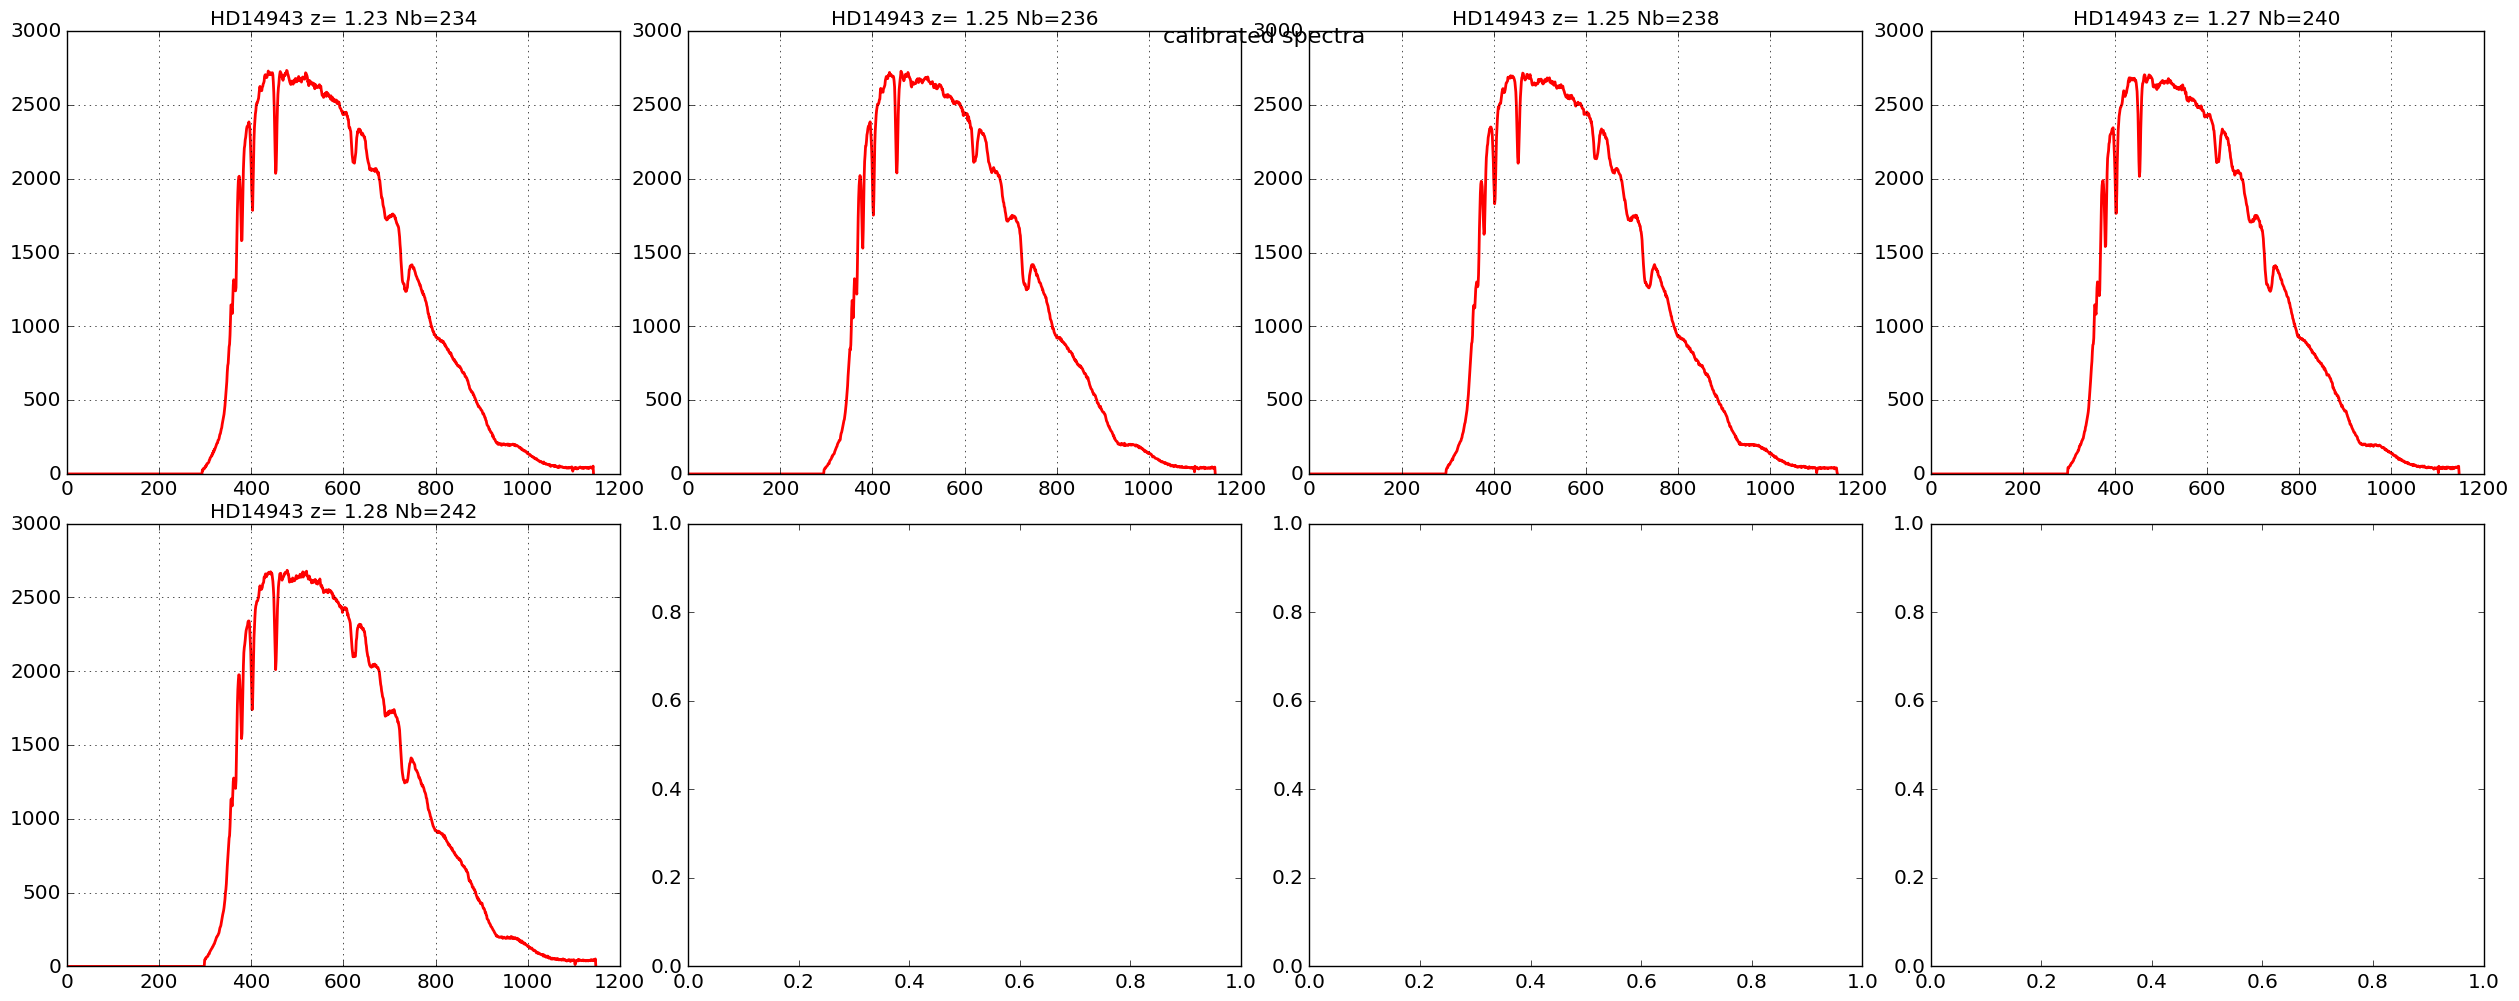

In [140]:
ShowSpectra(all_rightspectra,all_titles,object_name,dir_top_images,'calrightspectra.pdf')

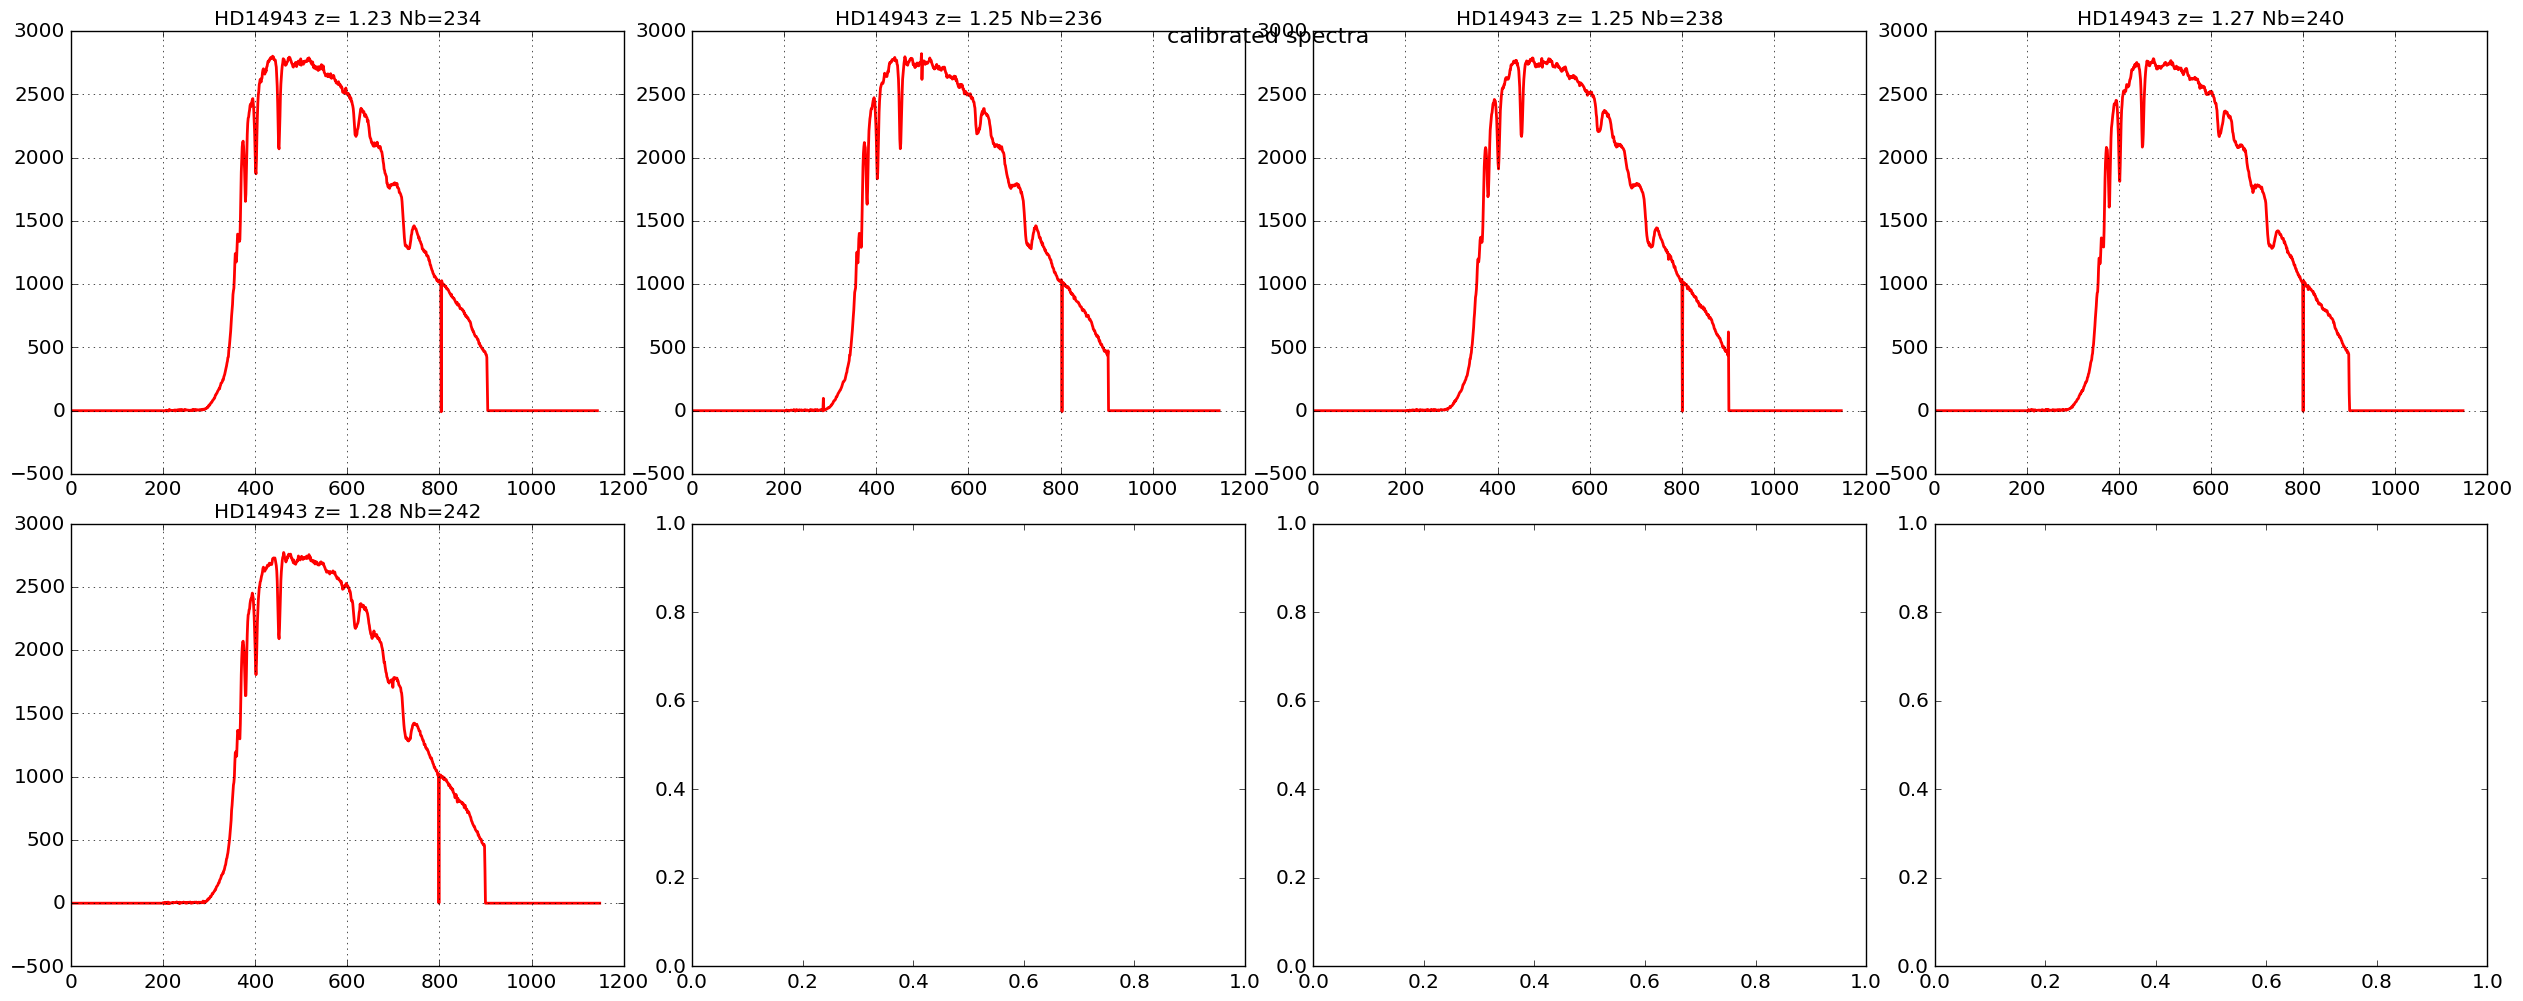

In [141]:
ShowSpectra(all_leftspectra,all_titles,object_name,dir_top_images,'calleftspectra.pdf')

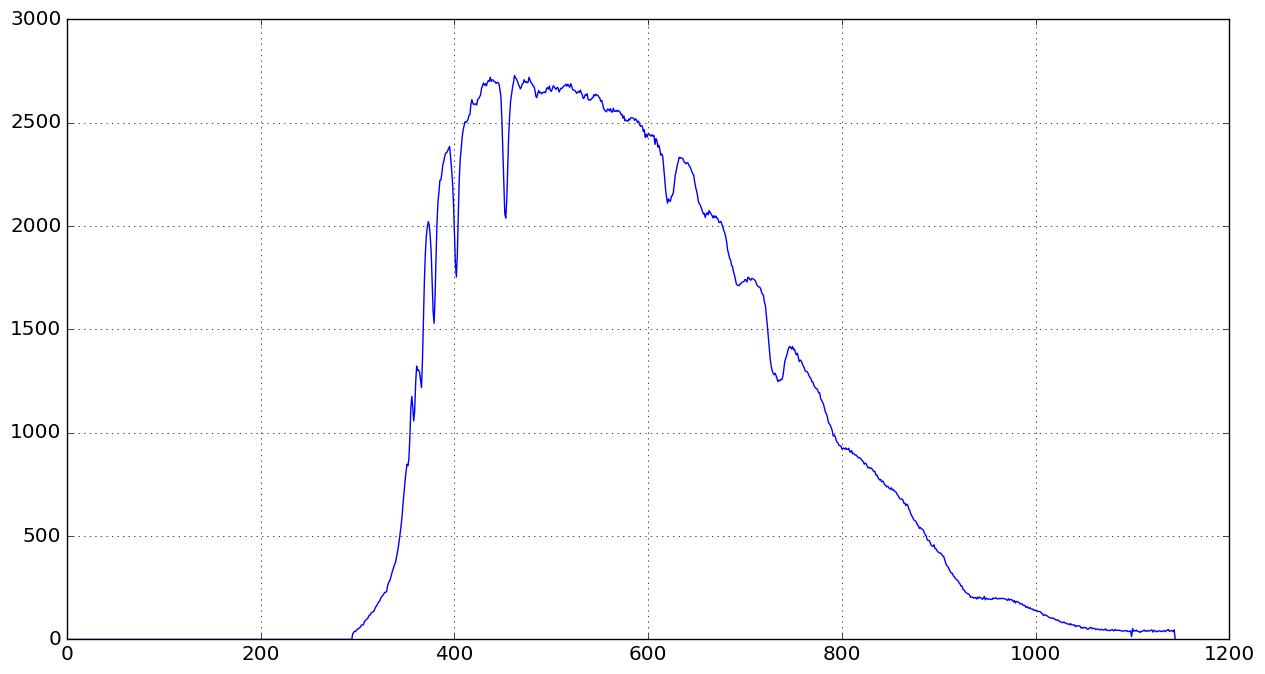

In [142]:
plt.figure(figsize=(15,8))
plt.plot(all_rightspectra[1])
#plt.xlim(0,500)
plt.grid(True)

## Read the simulated spectra

In [143]:
inputsim_filelist=os.listdir(simspecdir) 

In [144]:
if '.DS_Store' in inputsim_filelist:
    inputsim_filelist.remove('.DS_Store')
inputsim_filelist=np.array(inputsim_filelist)

In [145]:
print inputsim_filelist[0:5]

['RT_CT_pp_us_sa_rt_HD14943_Nev234_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev236_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev238_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev240_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev242_y2016_m01_aver_spectra.fits']


In [146]:
print re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m01_aver_spectra.fits',inputsim_filelist[0])

['234']


In [147]:
indexes_simfiles= [] # global list
filelist_simfitspec= []  # global list

In [148]:
#%%cython

import numpy as np
import re

def MakeSimFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                str_num=re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m01_aver_spectra.fits',file)
                number=int(str_num[0])
                indexes_files.append(number)
    return indexes_files, filelist_fitsimages

In [149]:
indexes_simfiles, filelist_simfitspec=MakeSimFileList(simspecdir,inputsim_filelist)   # filter to take only fits file

In [150]:
# transform into numpy arrays
indexes_simfiles=np.array(indexes_simfiles)
filelist_simfitspec=np.array(filelist_simfitspec)

In [151]:
print indexes_simfiles

[234 236 238 240 242]


In [152]:
sorted_simindexes=np.argsort(indexes_simfiles) # sort the file indexes

In [153]:
sorted_simindexes

array([0, 1, 2, 3, 4])

In [154]:
sorted_simnumbers=indexes_simfiles[sorted_simindexes] # check the ordering with argsort is correct

In [155]:
print sorted_simnumbers # check

[234 236 238 240 242]


In [156]:
sorted_simfiles=filelist_simfitspec[sorted_simindexes] # now sort the filenames

In [157]:
print sorted_simfiles[0:5] # check

[ '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_18/NoFilter_400/RT_CT_pp_us_sa_rt_HD14943_Nev234_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_18/NoFilter_400/RT_CT_pp_us_sa_rt_HD14943_Nev236_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_18/NoFilter_400/RT_CT_pp_us_sa_rt_HD14943_Nev238_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_18/NoFilter_400/RT_CT_pp_us_sa_rt_HD14943_Nev240_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_18/NoFilter_400/RT_CT_pp_us_sa_rt_HD14943_Nev242_y2016_m01_aver_spectra.fits']


In [158]:
hdu_list=fits.open(sorted_simfiles[0])
header=hdu_list[0].header

In [159]:
print header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  OBJ_NAME= 'HD14943 '                                                            AIRMASS =    1.230000019073486                                                  UNITS   = 'wavelength in nm'                                                    DATE    = '2017-01-19T01:48:19.161'                                             EXPOSURE=                 20.0                                                  FILENAME= 'trim_20170118_234.fits'                                              COMMENT Prediction of observable SPECTRA                                        END                                                                                                                     

In [160]:
 table_data=hdu_list[1].data

In [161]:
print table_data.columns

ColDefs(
    name = 'WAVELENGTH'; format = 'E'
    name = 'SEDcalspec'; format = 'E'
    name = 'Atmosphere'; format = 'E'
    name = 'QE'; format = 'E'
    name = 'SEDxQExATM'; format = 'E'
)


In [162]:
simwavelength = table_data.field('WAVELENGTH')
simsed        = table_data.field('SEDcalspec')
simatm        = table_data.field('Atmosphere')
simqe         = table_data.field('QE')
simspectra    = table_data.field('SEDxQExATM')

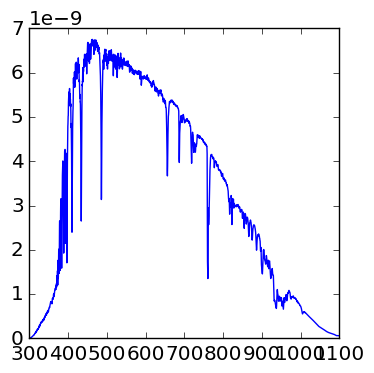

In [163]:
plt.plot(simwavelength,simspectra )

In [164]:
#%%cython

#import numpy as np
#from astropy.io import fits
def BuildSimSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildSimSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    
    all_simwavelength = []
    all_simspectra = []
    all_simatmosphere = []
    all_simqe = []
    all_simsed = []
    
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        print idx
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
                
        #print header
        date_obs = header['DATE']
        airmass = header['AIRMASS']
        expo = header['EXPOSURE']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        simwavelength = table_data.field('WAVELENGTH')
        simsed        = table_data.field('SEDcalspec')
        simatm        = table_data.field('Atmosphere')
        simqe         = table_data.field('QE')
        simspectra    = table_data.field('SEDxQExATM')
        
        
        all_simwavelength.append(simwavelength)
        all_simspectra.append(simspectra)
        all_simatmosphere.append(simatm)
        all_simqe.append(simqe)
        all_simsed.append(simsed)
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
            
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed

In [165]:
# crash because it blows up fits IO capability : too many files open
#all_simdates,all_simairmass,all_simtitles,all_simheader,all_simexpo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed=BuildSimSpec(sorted_simfiles,sorted_simnumbers,object_name)

In [166]:
# better open a singel file produced by view_SimSpectrum

hdu_list=fits.open(simspectrasummary)
header=hdu_list[0].header
print header
simspectra_data=hdu_list[0].data

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1888                                                  NAXIS2  =                    6                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

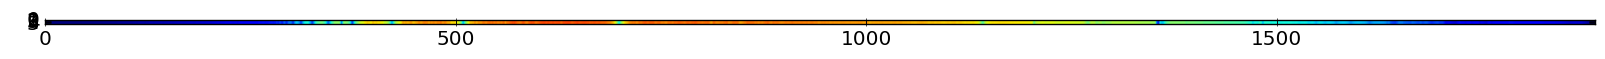

In [167]:
plt.figure(figsize=(20,20))
plt.imshow(simspectra_data[:,:],vmin=0,vmax=8e-9)

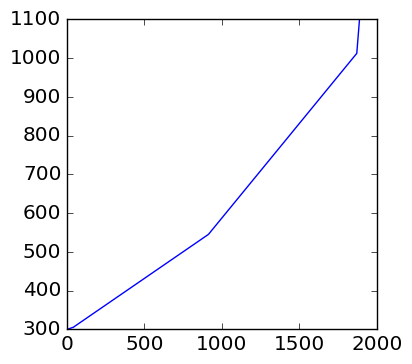

In [168]:
plt.plot(simspectra_data[0,:])
wl_simspectra=simspectra_data[0,:]

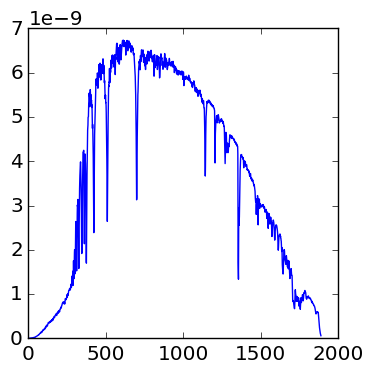

In [169]:
plt.plot(simspectra_data[2,:])

In [170]:
wl_O2Aline=759.37
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175

#wl_Naline=589.592+1
#wl_Heline=587.5618-1


#wl_Hgline=546.073
#wl_Feline=527.039
wl_calib= np.array([wl_O2Aline, wl_Haline, wl_Hbline, wl_Hgline ])

## Comparison of spectra

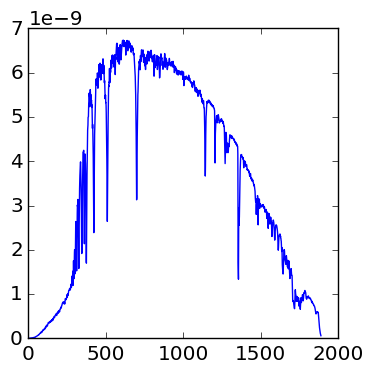

In [171]:
plt.plot(simspectra_data[2,:])

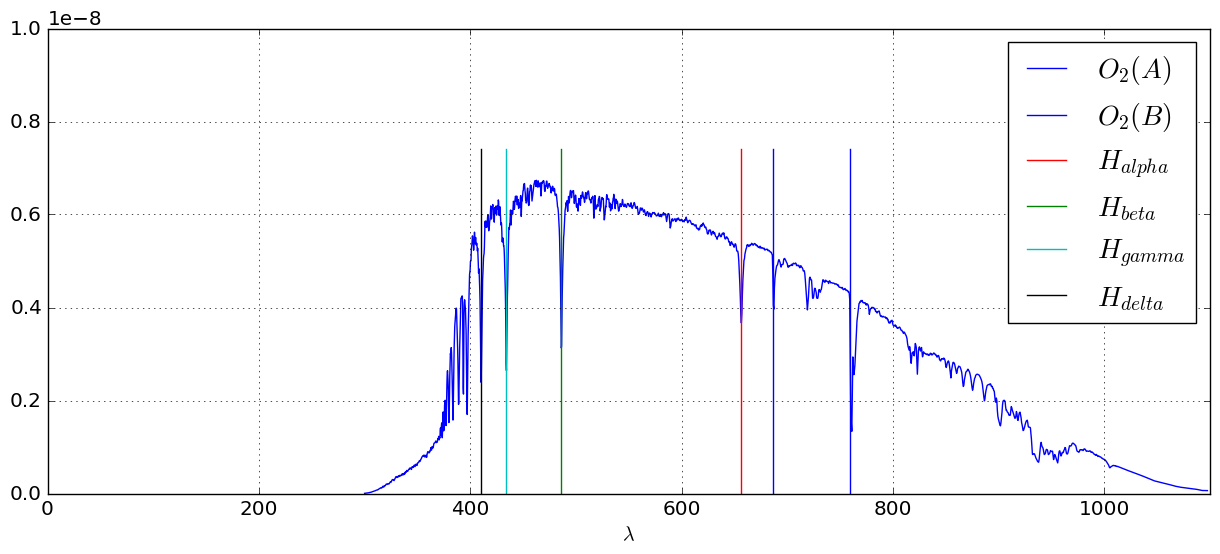

In [172]:
ymax=simspectra_data[2,:].max()*1.1
ymin=simspectra_data[2,:].min()
plt.figure(figsize=(15,6))
plt.plot(simspectra_data[0,:],simspectra_data[2,:])

plt.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
plt.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
plt.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
plt.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
plt.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
plt.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)

plt.legend(loc='best',fontsize=20)
plt.ylim(0.,1e-8)
plt.xlim(0,1100)
plt.xlabel("$\lambda$")
plt.grid(True)

In [173]:
#%%cython
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib as mpl    
def CalibrateSpectra(all_spectra,fit_param,all_titles,object_name,figname):
    """
    CalibrateSpectra(all_spectra,fit_param,all_titles,object_name): 
    ==============
    """

    NBSPECTRA=len(all_spectra)
    MAXIMGROW=int(NBSPECTRA/4)+1
    
    NBWL=all_spectra[0].shape[0]
    
    all_wl=[]
    
    
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(25,10))
    f.tight_layout()

    for index in np.arange(0,NBSPECTRA):
        ix=index%4
        iy=index/4
        spectrum=all_spectra[index]
        spectrum_pix=np.arange(0,spectrum.shape[0])
        fitcurve = np.poly1d(fit_param[index])
        spectrum_wl=fitcurve(spectrum_pix)
        
        all_wl.append(spectrum_wl)
        
        ymax=spectrum.max()*1.1
        ymin=0
        
        axarr[iy,ix].plot(spectrum_wl,spectrum,'b-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(ymin,ymax)
        axarr[iy,ix].set_xlim(0.,1200.)
        axarr[iy,ix].grid(True)

        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
        
        axarr[iy,ix].plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
        axarr[iy,ix].plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
        axarr[iy,ix].plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
        axarr[iy,ix].plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
        
        figfilename=os.path.join(dir_top_images,figname)
        plt.savefig(figfilename)
        
    return all_wl
        

In [174]:
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib as mpl    
def CalibrateSpectra2(all_spectra,fit_param,all_titles,object_name,figname):
    """
    CalibrateSpectra2: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(all_spectra)
    NBWL=all_spectra[0].shape[0]
    all_wl= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    
    for index in np.arange(0,NBSPECTRA):
        if index==0 :  # Skip first
            continue
        ix=index%5
        iy=index/5
        
           
        spectrum=all_spectra[index]
        
        all_ymin.append(spectrum.min())
        all_ymax.append(spectrum.max())
        
        spectrum_pix=np.arange(0,spectrum.shape[0])
        fitcurve = np.poly1d(fit_param[index])
        spectrum_wl=fitcurve(spectrum_pix)
        
        all_wl.append(spectrum_wl)
        
        ax.plot(spectrum_wl,spectrum,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    ax.set_xlim(0.,1200.)
    #ax.set_ylim(0,ymax)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)

    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    title='Calibrated Spectrum for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("spectrum")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)
    
    return all_wl 
       

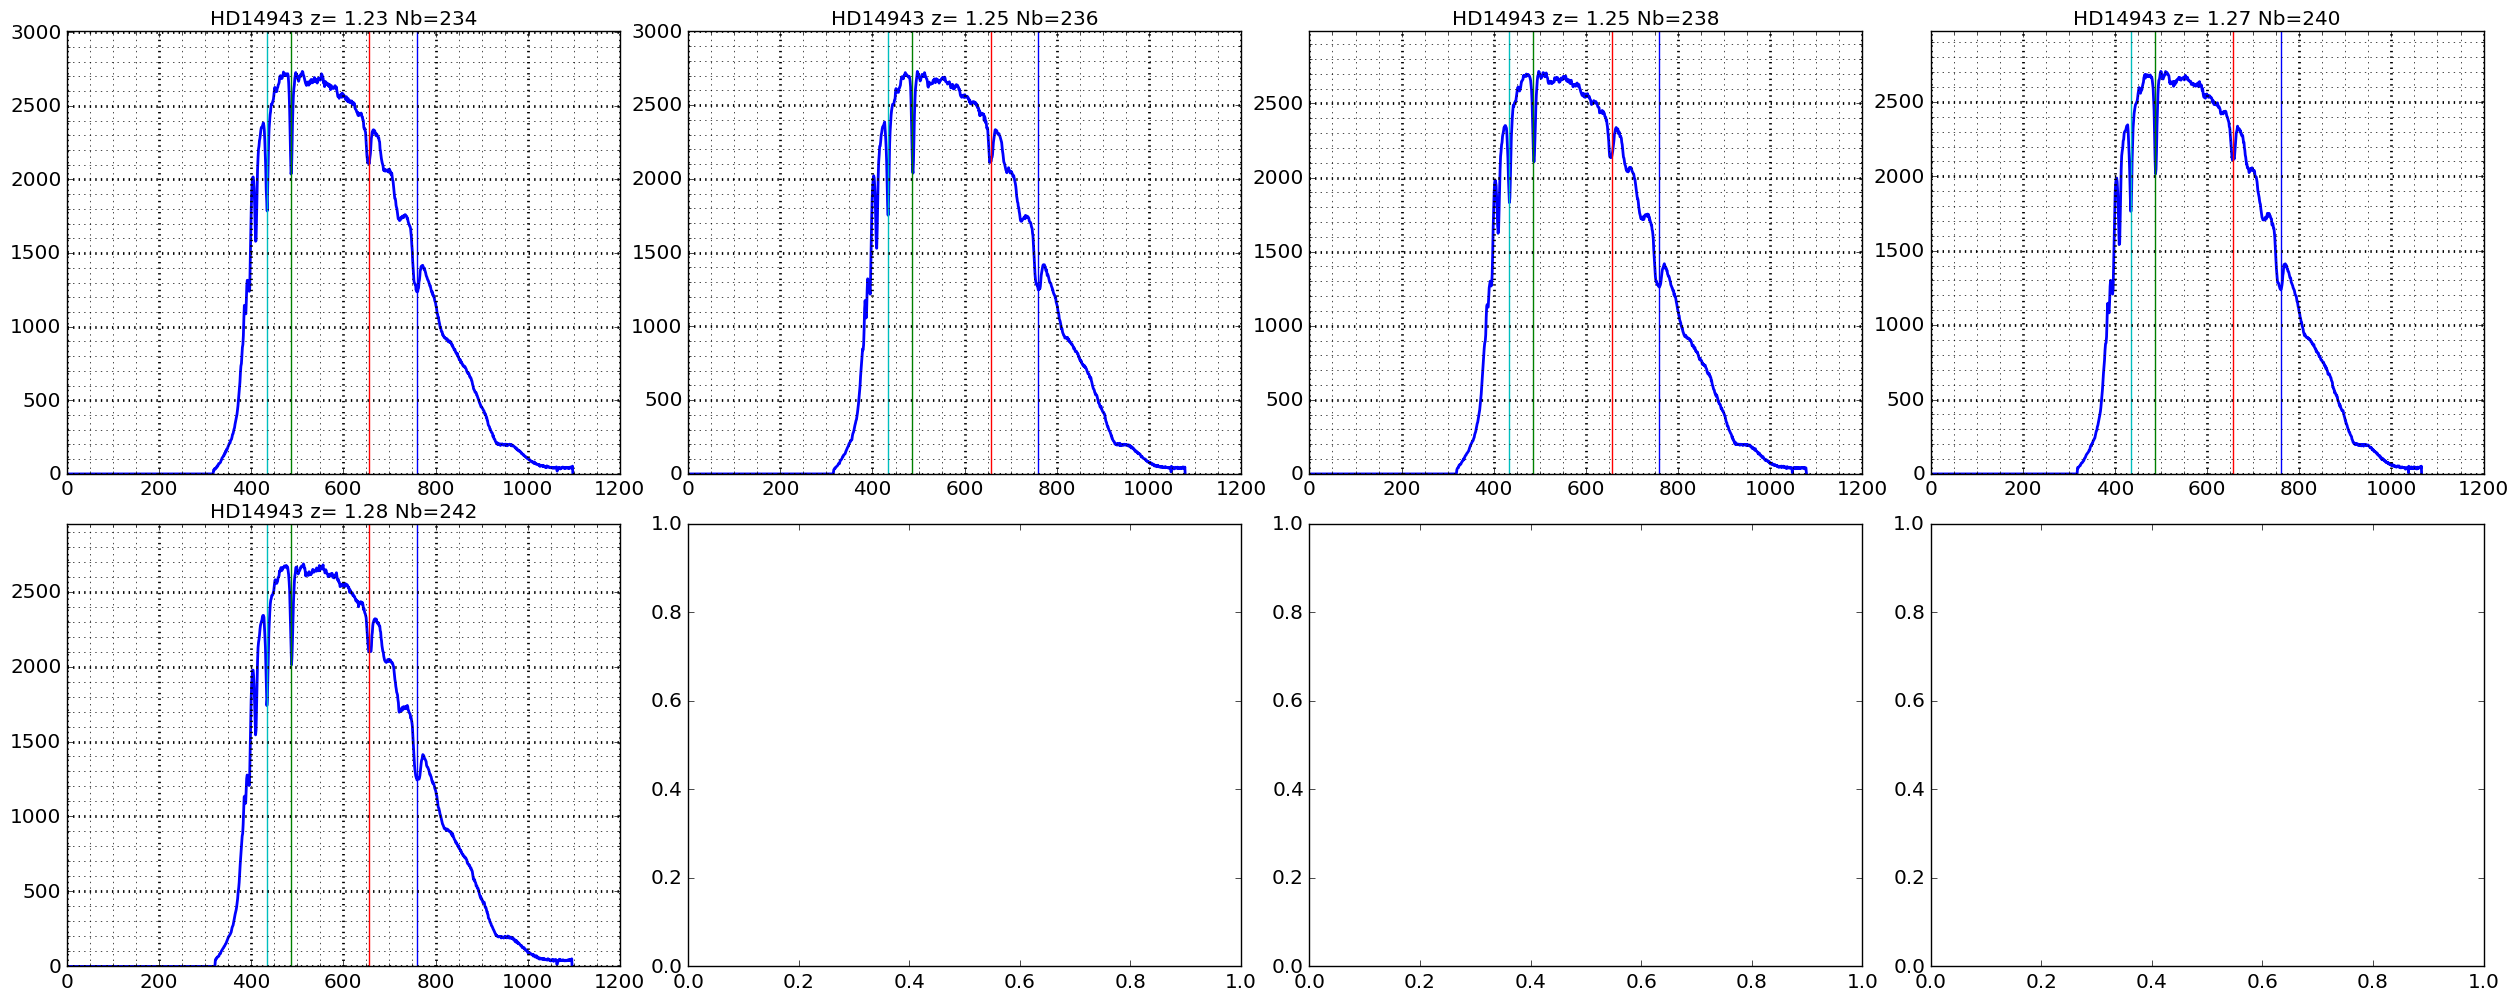

In [175]:
calibrated_rightspectra_wl=CalibrateSpectra(all_rightspectra,fitparam_rightspectra,all_titles,object_name,'calrightspectra1.pdf')


In [176]:
calibrated_rightspectra_wl[1]

array([  -41.89992296,   -40.60566419,   -39.31195612, ...,  1077.35358813,
        1078.01894242,  1078.683746  ])

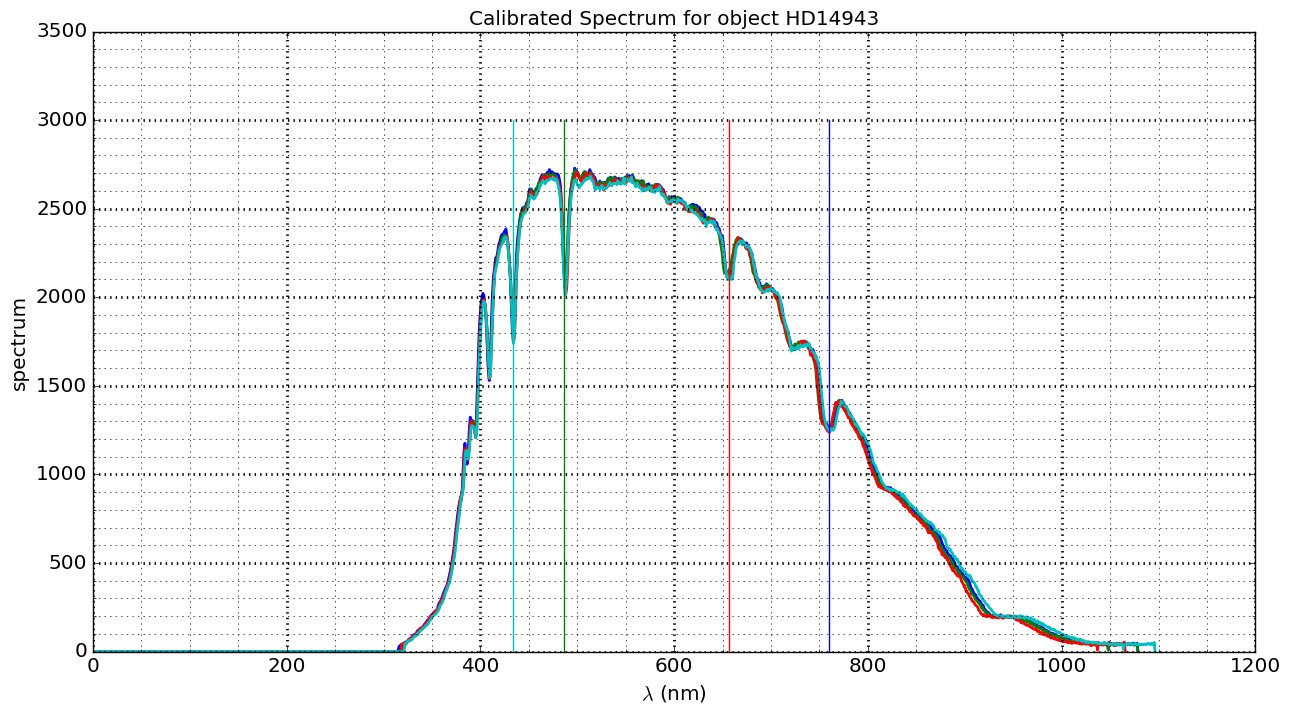

In [177]:
calibrated_rightspectra_wl2=CalibrateSpectra2(all_rightspectra,fitparam_rightspectra,all_titles,object_name,'calrightspectra2.pdf')

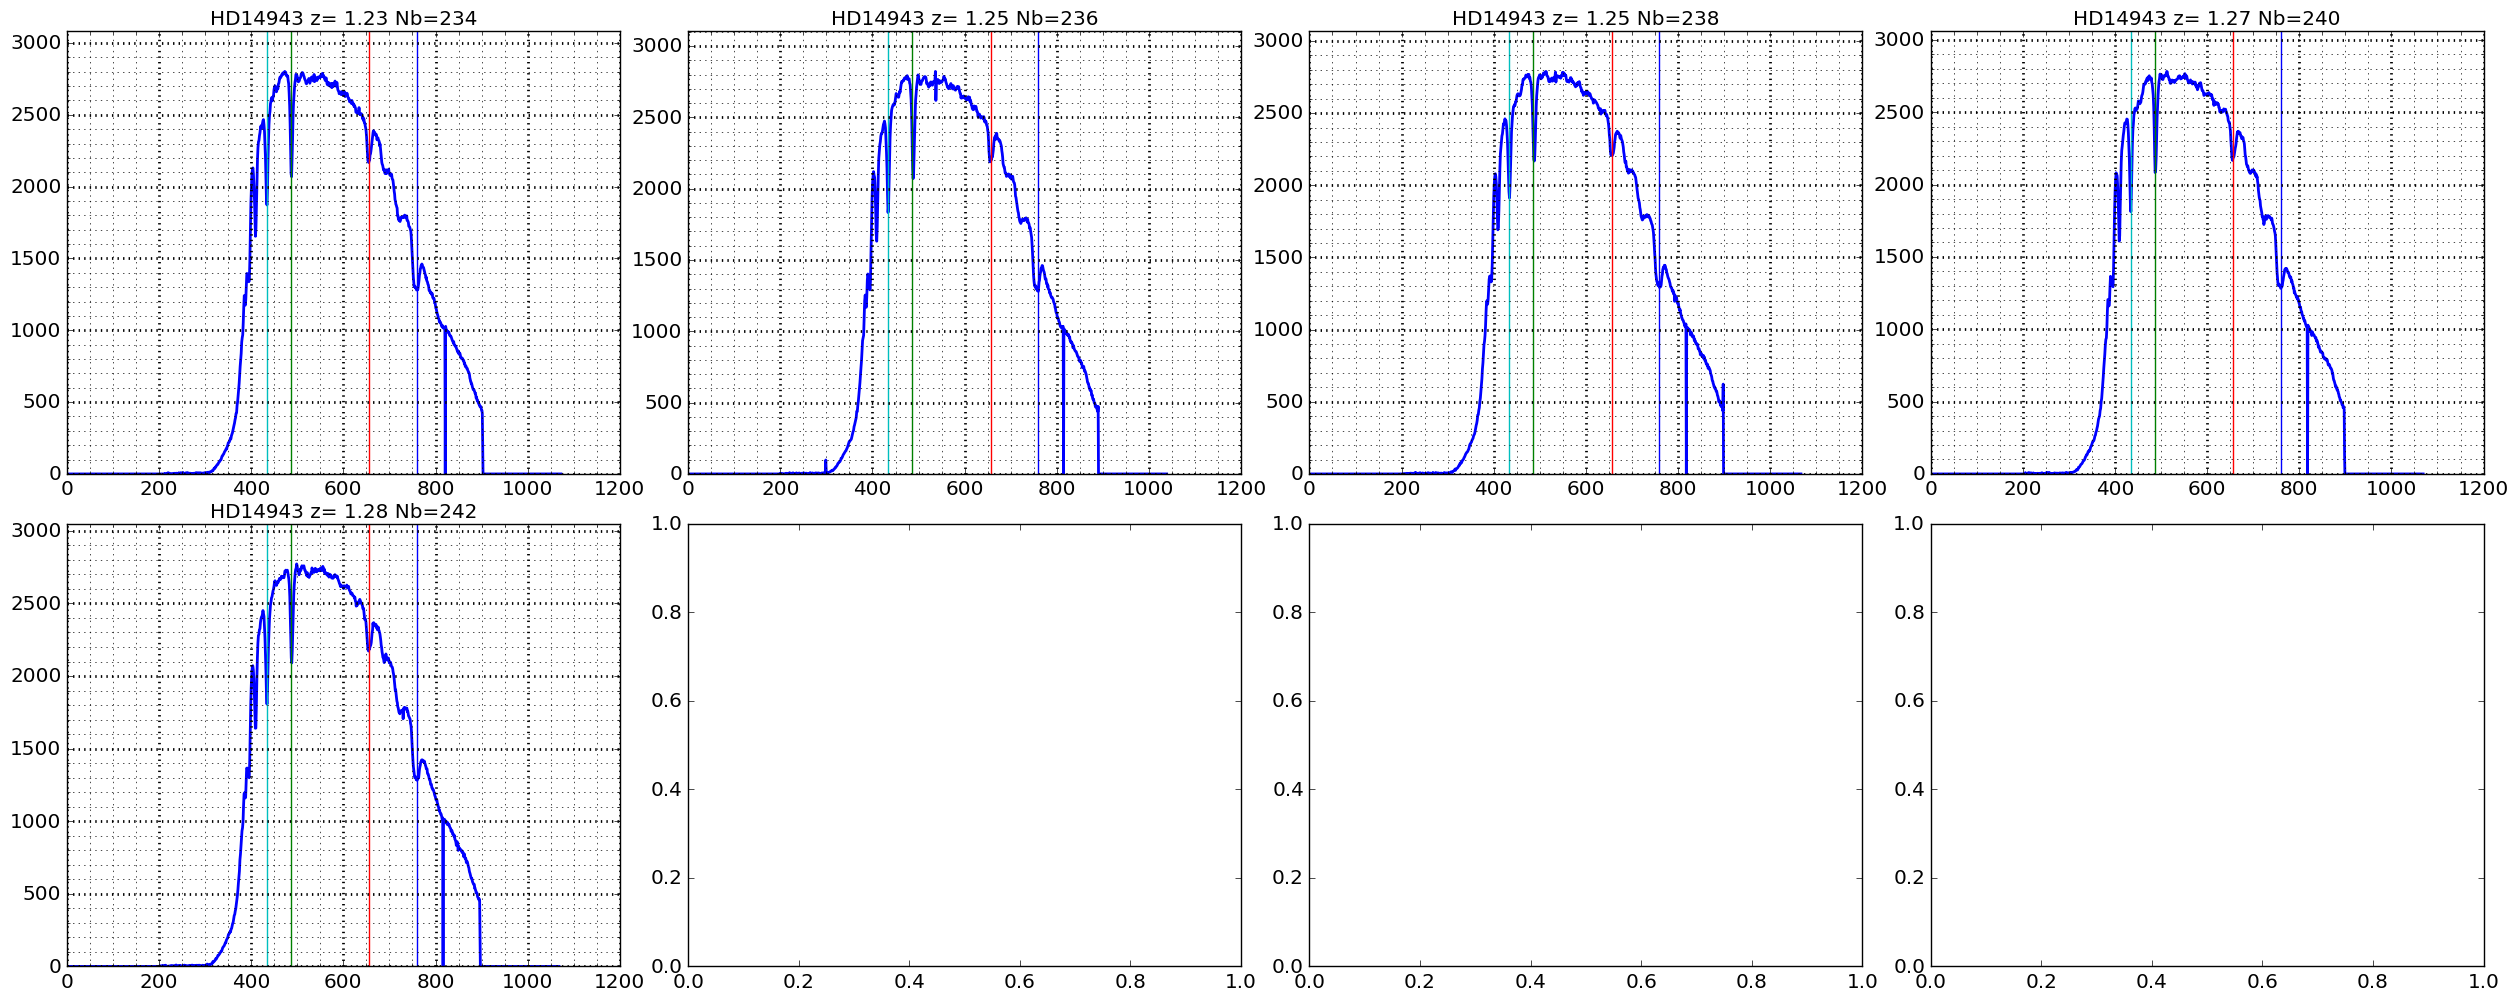

In [178]:
calibrated_leftspectra_wl=CalibrateSpectra(all_leftspectra,fitparam_leftspectra,all_titles,object_name,'calleftspectra1.pdf')

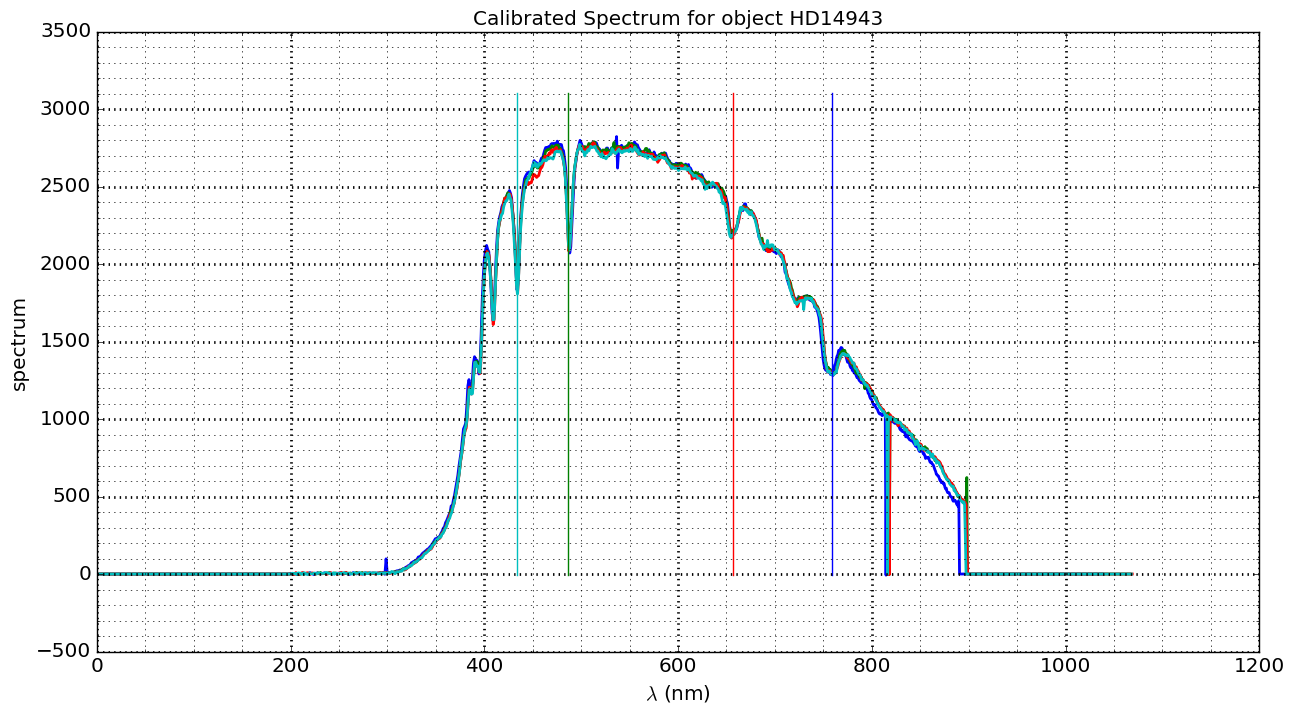

In [179]:
calibrated_leftspectra_wl2=CalibrateSpectra2(all_leftspectra,fitparam_leftspectra,all_titles,object_name,'calleftspectra2.pdf')

### Save outputfilename
Results of the fits for right and left spectra are saved as images

In [180]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^finalSpectra_(.*)',short_infilename)
    short_outfilename='calibSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [181]:
newfullfilenames[0:5]

['./spectrum_calibspec/calibSpectra_HD14943_20170118_234.fits',
 './spectrum_calibspec/calibSpectra_HD14943_20170118_236.fits',
 './spectrum_calibspec/calibSpectra_HD14943_20170118_238.fits',
 './spectrum_calibspec/calibSpectra_HD14943_20170118_240.fits',
 './spectrum_calibspec/calibSpectra_HD14943_20170118_242.fits']

In [182]:
#
#  New fashion to save a binary table outside the primary header
#
for idx,file in np.ndenumerate(newfullfilenames):
    primhdu = fits.PrimaryHDU(header=all_header[idx[0]])   # make an primary HDU without data
    
    col1=fits.Column(name='CalibLeftSpecWL',format='E',array=calibrated_leftspectra_wl[idx[0]])
    col2=fits.Column(name='CalibLeftSpec',format='E',array=all_leftspectra[idx[0]])
    col3=fits.Column(name='CalibLeftSpecFitParam',format='E',array=fitparam_leftspectra[idx[0]])
    col4=fits.Column(name='CalibRightSpecWL',format='E',array=calibrated_rightspectra_wl[idx[0]])
    col5=fits.Column(name='CalibRightSpec',format='E',array=all_rightspectra[idx[0]])
    col6=fits.Column(name='CalibRightSpecFitParam',format='E',array=fitparam_rightspectra[idx[0]])
    cols=fits.ColDefs([col1,col2,col3,col4,col5,col6])
    
    tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    thdulist = fits.HDUList([primhdu, tbhdu])
    
    thdulist.writeto(file,clobber=True)